In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [5]:
train.shape, test.shape

((2935849, 6), (214200, 3))

In [6]:
train.dtypes, test.columns

(date               object
 date_block_num      int64
 shop_id             int64
 item_id             int64
 item_price        float64
 item_cnt_day      float64
 dtype: object,
 Index(['ID', 'shop_id', 'item_id'], dtype='object'))

In [7]:
monthly_data = train.pivot_table(
    index = ['shop_id','item_id'],
    values = ['item_cnt_day'],
    columns = ['date_block_num'],
    fill_value = 0,
    aggfunc='sum')

In [8]:
monthly_data.head(10)

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        36                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        40                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        42                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        43                 1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        49                 0   2  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
        36       0  0  0  0  0  
        40       0  0  0  0  0  
        42       0  0  0  0  0  
        43       0  0  0  0  0  
        49       0  0  0  0  0  

[10 rows x 34 columns]

In [9]:
monthly_data.tail(10)

item_cnt_day                             ...                 \
date_block_num            0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                          ...                  
59      22144              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22145              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22150              0  0  0  0  0  0  1  1  0  0  ...  0  0  0  0  0   
        22151              2  0  1  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22153              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22154              1  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0  0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0  0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0  0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
59      22144    0  0  0  0  0  
        22145    0  0  0  0  0  
        22150    0  0  0  0  0  
        22151    0  0  0  0  0  
        22153    0  0  0  0  0  
        22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[10 rows x 34 columns]

In [10]:
monthly_data.reset_index(inplace = True)
monthly_data.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [11]:
train_data = monthly_data.drop(columns= ['shop_id','item_id'], level=0)

In [12]:
train_data.head()

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  

[5 rows x 34 columns]

In [13]:
train_data.fillna(0,inplace = True)
train_data.head()

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  

[5 rows x 34 columns]

In [14]:
x_train = np.expand_dims(train_data.values[:,:-1],axis = 2)
y_train = train_data.values[:,-1:]

In [15]:
test_rows = monthly_data.merge(
    test,
    on = ['item_id','shop_id'],
    how = 'right')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [16]:
test_rows.head()

,item_id,shop_id,"(shop_id, )","(item_id, )","(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)",...,"(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)",ID
0,5037,5,5.0,5037.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0
1,5320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5233,5,5.0,5233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2
3,5232,5,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,5268,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [17]:
x_test = test_rows.drop(test_rows.columns[:5], axis=1).drop('ID', axis=1)

In [18]:
x_test

,"(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
x_test.fillna(0,inplace = True)

In [20]:
x_test.head()

,"(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
x_test = np.expand_dims(x_test,axis = 2)

In [22]:
print(x_train.shape,y_train.shape,x_test.shape)

(424124, 33, 1) (424124, 1) (214200, 33, 1)


In [23]:
model = tf.keras.models.Sequential()    
model.add(LSTM(64, input_shape=(33, 1), return_sequences=False))
model.add(Dense(1))
    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

2022-07-15 14:38:51.895026: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=4096,
    verbose=1, 
    shuffle=True,
    validation_split=0.4)

2022-07-15 14:38:52.478668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
63/63 [==============================] - 32s 475ms/step - loss: 24.7415 - mean_squared_error: 24.7415 - val_loss: 2.5772 - val_mean_squared_error: 2.5772
Epoch 2/10
63/63 [==============================] - 29s 462ms/step - loss: 24.5191 - mean_squared_error: 24.5191 - val_loss: 2.4717 - val_mean_squared_error: 2.4717
Epoch 3/10
63/63 [==============================] - 30s 483ms/step - loss: 24.4181 - mean_squared_error: 24.4181 - val_loss: 2.4229 - val_mean_squared_error: 2.4229
Epoch 4/10
63/63 [==============================] - 29s 468ms/step - loss: 24.3417 - mean_squared_error: 24.3417 - val_loss: 3.4108 - val_mean_squared_error: 3.4108
Epoch 5/10
63/63 [==============================] - 29s 466ms/step - loss: 24.3576 - mean_squared_error: 24.3576 - val_loss: 2.3882 - val_mean_squared_error: 2.3882
Epoch 6/10
63/63 [==============================] - 29s 463ms/step - loss: 24.2883 - mean_squared_error: 24.2883 - val_loss: 2.3695 - val_mean_squared_error: 2.3695
Epoch 7/10

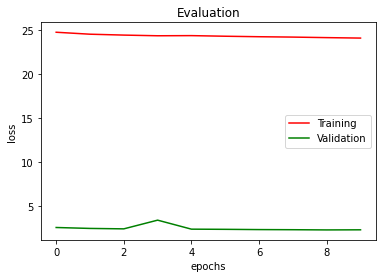

In [25]:
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Evaluation')
plt.show()

In [26]:
test_predict = model.predict(x_test)

In [27]:
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':test_predict.ravel()})
submission['item_cnt_month'] = submission['item_cnt_month']
submission.to_csv('submission.csv',index = False)